8.2 Precision and Recall

$s=s_T (true\ strategy\ count)+s_F (false\ strategy\ count)$ 

then for $\theta=\frac{s_T}{s_F}, s_T=\frac{\theta}{1+\theta}, s_F=\frac{1}{1+\theta}$

then for $\alpha=FP\ rate, \beta=FN\ rate$

$FP=\alpha s_F, TN=(1-\alpha ) s_F, TP=( 1-\beta )s_T, FN=\beta s_T$

$ Precision=\frac{TP}{FP+TP}=\frac{(1-\beta)\theta}{(1-\beta)\theta+\alpha} \\ Recall=\frac{TP}{TP+FN}=1-\beta$ 

Finance에서는 일반적으로 $\theta$ 가 작기 때문에 precision이 작고 대부분의 발견이 false일 가능성이 크다.

8.3 Precision and Recall under Multiple Testing

만약 각 testing이 독립이라면 FP, FN은 아래와 같다.

$\alpha_K=1-(1-\alpha)^K (FWER), \beta_k=\beta^K$ (type I: 한 번 이상 에러가 발생할 확률(하나라도 실패하면 실패), type II: 모두 에러가 발생할 확률(모든 positive를 놓쳤는지가 중요))

$
Precision=\frac{(1-\beta_K)\theta}{(1-\beta_K)\theta+\alpha_K} \\
Recall=1-\beta_K
$

8.4 The Sharpe Ratio

Portfolio의 Return이 stationary하고 ergodic(어떤 프로세스의 장기적인 평균이 결국 조건부 평균과 같아지면) asymptotic distribution of $\hat{SR}=\frac{E[\{r_t\}]}{\sqrt{V[\{r_t\}]}}$ is => Return이 IID일 필요는 없다.

$\hat{SR}-SR \rightarrow N[0, \frac{1+\frac{1}{2}SR^2-\gamma_3 SR+\frac{\gamma_4-3}{4}SR^2}{T}], \gamma_3=skewness, \gamma_4=kurtosis $ by [Mertens (2002)](https://www.scirp.org/journal/paperinformation?paperid=107040)



8.5 The "False Strategy Theorem"

SBuMT(Selection bias under multiple testing) expected maximum sharpe ratio와 expected sharpe ratio from a random trial로 측정할 수 있다.

$\{\hat{SR_k}\} k=1,..,K $ from IID gaussian, $\hat{SR_k} \sim [0, V[\hat{SR_k}]]$ then

$\frac{E[max_k\{\hat{SR_k}\}]}{\sqrt{V[\hat{SR_k}]}} \approx (1-\gamma) Z^{-1} [1-\frac{1}{K}]+\gamma Z^{-1} [1-\frac{1}{Ke}]$ 

$Z^{-1}$: inverse of standard gaussian CDF, e: Euler's number, $\gamma$: Euler-Mascheroni number

8.6 Experimental Results

Snippet 8.1 Experimental Validation of The False Strategy Theorem

Compare analytical solution 8.5 such that $E[max_k \{\hat{SR}\}]$ and monte carlo simulated $\hat{E[max_k \{\hat{SR}\}]}$ by mean of maximum sharpe ratio of each K trial 

In [15]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from tqdm import tqdm

def get_expected_max_sr(n_trials:int, mean_sr:float, std_sr:float)->float:
    sharpes_ratio = (1-np.euler_gamma)*norm.ppf(1 - 1/n_trials)+np.euler_gamma*norm.ppf(1 - 1/(np.e*n_trials))
    return mean_sr + sharpes_ratio * std_sr


def get_simulated_max_sr(n_trial_list, mean_sr:float, std_sr:float, n_simulations:int)->float:
    rng=np.random.RandomState()
    ret=None
    for n_trials in tqdm(n_trial_list):
        sr=pd.DataFrame(rng.randn(n_simulations, n_trials))
        sr=sr.sub(sr.mean(axis=1), axis=0)
        sr=sr.div(sr.std(axis=1), axis=0)
        sr=mean_sr + std_sr * sr
        if ret is None:
            ret=sr.max(axis=1).to_frame(name='max_sr')
            ret['n_trials'] = n_trials
        else:
            cur = sr.max(axis=1).to_frame(name='max_sr')
            cur['n_trials'] = n_trials
            ret=pd.concat([ret, cur], axis=0, ignore_index=True)
    return ret


n_trials=list(set(np.logspace(1, 4, 100).astype(int)))
sr_caled={i:get_expected_max_sr(i, mean_sr=0.0, std_sr=1.0) for i in n_trials}
sr_simulated=get_simulated_max_sr(n_trial_list=n_trials, mean_sr=0.0, std_sr=1.0, n_simulations=1000)

100%|██████████| 99/99 [00:03<00:00, 28.49it/s] 


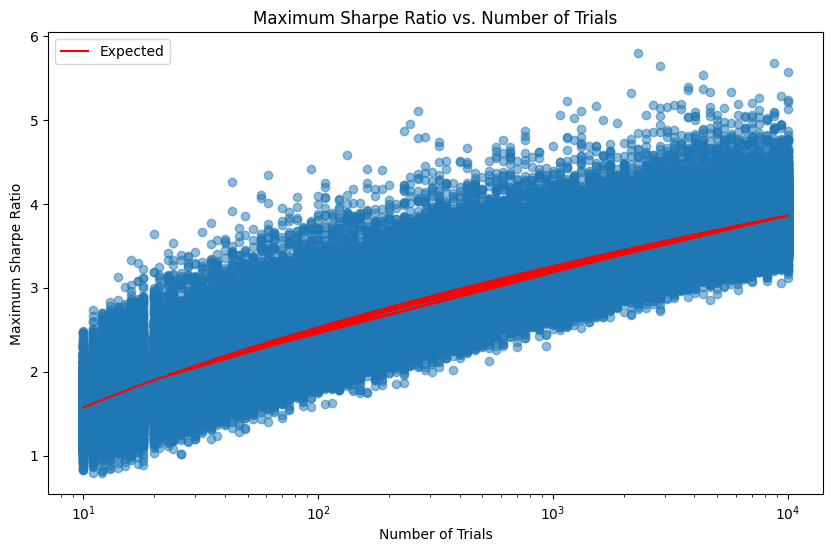

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(sr_simulated['n_trials'], sr_simulated['max_sr'], alpha=0.5)
plt.plot(n_trials, [sr_caled[i] for i in n_trials], label='Expected (Prior)', color='red')
plt.xscale('log')
plt.xlabel('Number of Trials')
plt.ylabel('Maximum Sharpe Ratio')
plt.title('Maximum Sharpe Ratio vs. Number of Trials')
plt.legend()
plt.show()

Snippet 8.2 Mean and Standard Deviation of The Prediction Errors

Calculate estimation error $e=\frac{\hat{E[max_k \{\hat{SR}\}]}}{E[max_k \{\hat{SR}\}]}-1$

In [17]:
def get_estimation_error(n_trial_list, n_simulations, n_calculations, mean_sr, std_sr):
    '''
    Calculate the estimation error for the maximum Sharpe ratio.
    n_trials: list of int, number of trials
    n_simulations: int, number of simulations
    n_calculations: int, number of calculations
    mean_sr: float, mean Sharpe ratio
    std_sr: float, standard deviation of Sharpe ratio
    '''
    sr_caled=pd.Series({i:get_expected_max_sr(i, mean_sr, std_sr) for i in n_trial_list})
    sr_caled=sr_caled.to_frame(name='max_sr')
    sr_caled.index.name='n_trials'
    err=pd.DataFrame()
    for i in range(n_calculations):
        sr_simulated=get_simulated_max_sr(n_trial_list=n_trial_list, mean_sr=mean_sr, std_sr=std_sr, n_simulations=n_simulations)
        sr_simulated=sr_simulated.groupby('n_trials').mean().reset_index()
        err_i=sr_simulated.merge(sr_caled, on='n_trials', suffixes=('_simulated', '_calculated'))
        err_i['estimation_error'] = err_i['max_sr_simulated'] / err_i['max_sr_calculated'] - 1
        err=pd.concat([err, err_i[['estimation_error', 'n_trials']]], axis=0, ignore_index=True)
    ret={'mean_err':err['estimation_error'].groupby(err['n_trials']).mean(), 'std_err':err['estimation_error'].groupby(err['n_trials']).std()}
    ret=pd.DataFrame.from_dict(ret, orient='columns')
    return ret

n_trials=list(set(np.logspace(1, 4, 100).astype(int)))
estimation_err=get_estimation_error(n_trials, n_simulations=100, n_calculations=10, mean_sr=0.0, std_sr=1.0)


100%|██████████| 99/99 [00:00<00:00, 236.45it/s]


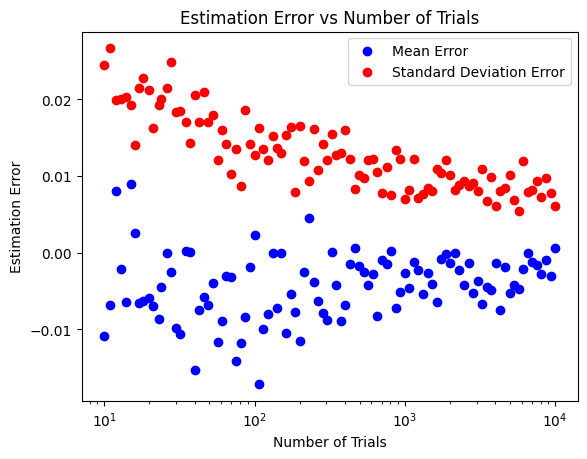

In [20]:
import matplotlib.pyplot as plt

plt.scatter(estimation_err.index, estimation_err['mean_err'], c='blue', label='Mean Error')
plt.scatter(estimation_err.index, estimation_err['std_err'],  c='red', label='Standard Deviation Error')
plt.xscale('log')
plt.xlabel('Number of Trials')
plt.ylabel('Estimation Error')
plt.title('Estimation Error vs Number of Trials')
plt.legend()
plt.show()


8.7 The Deflated Sharpe Ratio

시도 횟수가 늘어남에 따라서 $max_k \{\hat{SR_k}\} >> E[max_k \{\hat{SR_k}\}]$ 일지라도 False Strategy Theorem에 의해서 발견된 전략이 false positive일 수 있다. 

따라서 $H_0=E[max_k\{\hat{SR_k}\}]$ 귀무가설로 잡고 그 귀무가설을 기각하므로써 해당 전략이 통계적으로 유의미함을 보일 수 있도록하는 식 생각할 수 있다.

$\hat{DSR}=Z \begin{bmatrix}\frac{(\hat{SR}-E[max_k\{\hat{SR_k}\}])\sqrt{T-1}}{\sqrt{1-\hat{\gamma_3}\hat{SR}+\frac{\gamma_4-1}{4}\hat{SR}^2}} \end{bmatrix} = P(\hat{SR_{obs}} \ge \hat{SR} | SR_{true}=0 )$ (실제 SR이 0 일때 관측된 SR이 기대 SR보다 클 확률) 

이 값을 p-value 처럼 활용하는것이 가능하다.

8.7.1 Effective Number of Trials

실제로 각 전략의 각 trial은 독립적이지 않고 block correlation matrix와 비슷한 형태일 가능성이 높다.   
따라서 위의 식에 넣을때 전략의 correlation을 계산하고 chapter 7의 ONC 알고리즘에 넣어서 $ E[K] $를 구해서 보수적인 기준으로 활용할 수 있다. 

8.7.2 Variance Across Trials

한 번더 나아가서 아예 $K<<N$ 이도록 전략의 수를 줄일 수도 있다.
1. ONC로 clustering
2. 각 cluster의 return series의 covariance matrix를 구함 
3. min-variance optimization을 이용해서 각 전략의 weight를 구해서 cluster return time series를 구함 (대표 시계열 하나만 뽑음)

8.8 Familywise Error Rate

8.8.1 Sidak's Correction

$E[K]$는 정확하지는 않기 때문에 sidak의 correction을 적용하여 좀 더 정밀하게 계산이 가능하다. $\alpha_K, \beta_K$

8.8.2 Type I Errors under Multiple Testing

1. ONC로 $E[K]$ 구하고 Variance Across Trial로 $E[K]$개의 cluster return series 구하기
2. 각 cluster return에 대하여 asymptotically distribution을 통해서 SR가 0이하일 확률의 최대값을 구함
($\hat{z[0]}=max_k\{\hat{z[0]}_k\}, k=1,..,E[K]$)
3. $\alpha_k=1-Z[\hat{z[0]}]^{E[K]}$ (Z: standard gaussian cdf)

Snippet 8.3 Type I Error, With Numerical Example

In [24]:
def get_z_stat(sr_e, t, sr_t, skew=0.0, kurosis=3.0):
    z=(sr_e-sr_t)*np.sqrt(t-1)
    z/=np.sqrt((1-skew*sr_e+(kurosis-1)/4*sr_e**2))
    return z

def get_type_one_error(z,k):
    alpha=1-norm.cdf(z)
    alpha_k=1-(1-alpha)**k
    return alpha_k

t, skew, kurt, k, freq=1250, -3, 10, 10, 250
sr=1.25/np.sqrt(freq)
sr_t=1.0/np.sqrt(freq)
z=get_z_stat(sr_e=sr, t=t, sr_t=sr_t, skew=skew, kurosis=kurt)
alpha_k=get_type_one_error(z, k)
print(f"Type I Error (alpha_k): {alpha_k:.4f}")

Type I Error (alpha_k): 0.9751


8.8.3 Type || Errors under Multiple Testing

1. $\alpha_k$ 구하기
2. $z_{\alpha}=Z^{-1} [(1-\alpha_k)^{\frac{1}{K}}]$ (알파값에 대응되는 quantile 구하기)
3. $SR^*$ 나오지 않을 확률은 $\beta=Z[z_\alpha-\theta]$

$\theta=\frac{SR^*\sqrt{T-1}}{\sqrt{1- \gamma_3 \hat{SR}+\frac{\gamma_4-1}{4}\hat{SR}^2}}$

Snippet 8.4 Type II Error with Numerical Example

In [26]:
def get_theta(sr_e, t, sr_t, skew=0.0, kurosis=3.0):
    theta=(sr_t*np.sqrt(t-1))/(np.sqrt(1-skew*sr_e+(kurosis-1)/4*sr_e**2))
    return theta

def get_type_two_error(alpha_k, k, theta):
    z=norm.ppf((1 - alpha_k)**(1/k))
    beta=norm.cdf(z - theta)
    return beta

theta=get_theta(sr_e=sr, t=t, sr_t=sr_t, skew=skew, kurosis=kurt)
beta=get_type_two_error(alpha_k=alpha_k, k=k, theta=theta)
beta_k=beta**k
print(f"Type II Error (beta_k): {beta_k:.4f}")

Type II Error (beta_k): 0.0000


8.8.4 The Interaction between Type I and Type II errors

$\alpha \propto \frac{1}{\beta}$